## Create a Scoring Scheme for Listed Houses

#### Methodology
    - Select Attributes that are mostly complete and generally describe a property hollistically
    - Some inspection shows simple imputation is fallible to outlier irregularities,
        - Lot of rows though non-empty likely has garbage values. eg: There are houses with structure tax 1,2,3 etc.
          similarly for lotsizes, finished square feet etc.
        - So it's a safe bet to reject all data in bottom and top 5%ile for each column.
        - This gets us clean data of 1.3million points.
    - The distributions of attributes are mostly skewed, so 
        - Get quantile scores for each columns, i.e - Each value gets a score between 0-1.
        - The columns with descending desirability get scores of the form (1 - quant. score) i.e higher is worse.
        - Now all columns are transformed to uniform(0,1) distributions.
        - We call these component scores of attributes for the listing
    - Score for each listed property is chosen to be a linear combination of the component attribute scores
        - I choose to combine using Principal Component 1 coefficients.
    -Finally we obtain a distribution of the scores for the data pool

In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from collections import defaultdict

### Getting the data
    - We read the data
    -selecting Columns of interest
        - select some count data about the house, 
        - an oldness qualifier, 
        - a monetary qualifier, and 
        - house space-descriptors
    - Do some analysis on how much missing data exists
      - Given our choice of columns, not much. So we can safely discard the rows with NaNs
    

In [4]:
df = pd.read_csv("C://Users//ibipul//codes//datasets//Zillow_data//train_2016_v2.csv")

In [5]:
dfp = pd.read_csv("C://Users//ibipul//codes//datasets//Zillow_data/properties_2016.csv", low_memory = False)

In [6]:
# Picking the desirability attributes
desirability_attributes = []
key = ['parcelid']
count_attributes = ['bedroomcnt','bathroomcnt']
house_area_attributes = ['calculatedfinishedsquarefeet','lotsizesquarefeet']
oldness_attribute = ['yearbuilt']
monetary_attribute = ['structuretaxvaluedollarcnt']

desirability_attributes = count_attributes + house_area_attributes + oldness_attribute + monetary_attribute
all_attributes = key + desirability_attributes

In [7]:
dfr = dfp[all_attributes]

In [8]:
dfr[desirability_attributes].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
bedroomcnt,2973767.0,3.088949,1.275859,0.0,2.0,3.0,4.0,20.0
bathroomcnt,2973755.0,2.209143,1.077754,0.0,2.0,2.0,3.0,20.0
calculatedfinishedsquarefeet,2929652.0,1827.162124,1819.780469,1.0,1213.0,1572.0,2136.0,952576.0
lotsizesquarefeet,2709118.0,22822.805528,337592.366408,100.0,5688.0,7000.0,9898.0,328263808.0
yearbuilt,2925289.0,1964.261641,23.441319,1801.0,1950.0,1963.0,1981.0,2015.0
structuretaxvaluedollarcnt,2930235.0,170883.577166,402068.342015,1.0,74800.0,122590.0,196889.0,251486000.0


In [9]:
# Analysis of missing data
missing_df = dfr.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.loc[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')

In [10]:
missing_df

,column_name,missing_count
1,bedroomcnt,11450
2,bathroomcnt,11462
6,structuretaxvaluedollarcnt,54982
3,calculatedfinishedsquarefeet,55565
5,yearbuilt,59928
4,lotsizesquarefeet,276099


In [11]:
# Drop all rows with NaNs
dfr1 = dfr.dropna(axis=0, how='any')

In [12]:
dfr1[all_attributes].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
parcelid,2688057.0,1.280385e+07,2.413644e+06,10711725.0,11578096.0,12425993.0,13934696.0,163275886.0
bedroomcnt,2688057.0,3.229671e+00,1.181220e+00,0.0,3.0,3.0,4.0,20.0
bathroomcnt,2688057.0,2.275778e+00,1.041868e+00,0.0,2.0,2.0,3.0,20.0
calculatedfinishedsquarefeet,2688057.0,1.861594e+03,1.625765e+03,1.0,1238.0,1604.0,2188.0,952576.0
lotsizesquarefeet,2688057.0,2.258375e+04,3.377145e+05,104.0,5694.0,7000.0,9873.0,328263808.0
yearbuilt,2688057.0,1.962227e+03,2.285559e+01,1801.0,1949.0,1961.0,1979.0,2015.0
structuretaxvaluedollarcnt,2688057.0,1.705272e+05,2.814063e+05,1.0,75180.0,122831.0,197150.0,109192169.0


### Cleaning the dataset
    - Based on the table above, simple imputations of min values in count data, structuretaxvalue, or finished sq feet data
      would not make a lot of sense as I observed there are a range of values which are not natural.
      - For instance structure tax values are present like 1,2,3,4... again more than millions etc
        While practically higher values may make sense, as compared to lower values, 
        but I'd like to build on a standard range.
    -So my cleaning scheme:
        - reject data points for each column which are below 5%ile of the values.
        - reject data points for each column where data points are above 95% of values

In [13]:
# Imputations don't make much sense here, as there are a range of values for which we might have junk numbers
# Like some inspection showed there are cases where rooms are listed to have calculated finished sq foot of 1, or 
# structural tax of of 1 dollar. Often lot size, structural tax have ridiculously high values.
# So I intend to drop bottom 5%ile and top 95%ile data to get rid of outliers rather than taking up
# a hackneyed imputation
count_cols = ['bedroomcnt','bathroomcnt']
filter_by_percentile_cols = ['calculatedfinishedsquarefeet','lotsizesquarefeet', 'structuretaxvaluedollarcnt'] + count_cols


In [14]:
## Removal band specifies how much data we are rejecting from either end
removal_band = 5
quanitile_filter_dict = defaultdict()
for col in filter_by_percentile_cols:
    quanitile_filter_dict[col] = (np.percentile(dfr1[col],removal_band),np.percentile(dfr1[col],100 - removal_band))

In [15]:
dfr2 = dfr1.copy()
for key in quanitile_filter_dict.keys():
    print('Column: ', key,' Drop below: ', quanitile_filter_dict[key][0],' Drop Above: ', quanitile_filter_dict[key][1])
    dfr2 = dfr2[dfr2[key] > quanitile_filter_dict[key][0]]
    dfr2 = dfr2[dfr2[key] < quanitile_filter_dict[key][1]]


Column:  calculatedfinishedsquarefeet  Drop below:  860.0  Drop Above:  3583.0
Column:  lotsizesquarefeet  Drop below:  3200.0  Drop Above:  75658.0
Column:  structuretaxvaluedollarcnt  Drop below:  31392.0  Drop Above:  432375.2
Column:  bedroomcnt  Drop below:  2.0  Drop Above:  5.0
Column:  bathroomcnt  Drop below:  1.0  Drop Above:  4.0


In [16]:
# Clearly data looks much more sensible now, how ever our current data set is now 1.36 million points
dfr2[all_attributes].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
parcelid,1360701.0,1.300694e+07,2.554090e+06,10711725.0,11556686.0,12696274.0,14077908.0,163275886.0
bedroomcnt,1360701.0,3.422096e+00,4.938938e-01,3.0,3.0,3.0,4.0,4.0
bathroomcnt,1360701.0,2.323959e+00,4.634935e-01,1.5,2.0,2.0,3.0,3.5
calculatedfinishedsquarefeet,1360701.0,1.806830e+03,5.057303e+02,861.0,1420.0,1703.0,2108.0,3582.0
lotsizesquarefeet,1360701.0,8.887701e+03,7.449588e+03,3201.0,5985.0,7000.0,8650.0,75642.0
yearbuilt,1360701.0,1.964505e+03,1.952145e+01,1810.0,1954.0,1962.0,1978.0,2015.0
structuretaxvaluedollarcnt,1360701.0,1.469807e+05,8.090506e+04,31393.0,86000.0,129658.0,190205.0,432372.0


### Desirablity:
    - More Bedrooms & bath rooms more desirable, higher scores better
    - More finished square footing and more lot area means more desirable, higher scores will mean better
    - Buildings built later implies newer buildings, hence more desirable, higher score better
    - Lower tax value means higher desirability, Lower scores will mean better

In [17]:
from scipy import stats

In [18]:
ascending_desirability_columns = ['bedroomcnt','bathroomcnt','calculatedfinishedsquarefeet','lotsizesquarefeet', 'yearbuilt']
descending_desirability_columns = ['structuretaxvaluedollarcnt']
quantile_score_columns = ascending_desirability_columns + descending_desirability_columns
parcel_ids = pd.DataFrame(dfr2['parcelid'])


In [19]:
#Creating the data frame with Quantile scores of the data
# This also removes the need to normalise columns, as the data is now mapped to 0-1 range, for all
quantile_score_frame = pd.DataFrame({'structuretaxvaluedollarcnt_score': 1 - (stats.rankdata(dfr2['structuretaxvaluedollarcnt'], 
                                                                     "average")/len(dfr2['structuretaxvaluedollarcnt']))})
score_names = ['structuretaxvaluedollarcnt_score']
for col in ascending_desirability_columns:
    quantile_score_frame[col+'_score'] = stats.rankdata(dfr2[col], "average")/len(dfr2[col])
    score_names += [col + '_score']

quantile_score_frame['parcelid'] = parcel_ids.iloc[:,0].values

In [20]:
all_score_columns = score_names + ['parcelid']

In [21]:
dfr2.head(5)

,parcelid,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,lotsizesquarefeet,yearbuilt,structuretaxvaluedollarcnt
31,11585547,3.0,2.0,2077.0,6490.0,1926.0,207035.0
43,11759947,4.0,2.0,1931.0,5420.0,1957.0,122915.0
101,12606547,3.0,3.0,2166.0,22073.0,2005.0,363000.0
109,12757147,3.0,2.0,1300.0,4917.0,1950.0,76253.0
110,12757947,3.0,2.0,1222.0,5500.0,1951.0,116069.0


In [22]:
quantile_score_frame[all_score_columns].head(5)
# We can see how the quantile scores are behaving as we set up the desirability definitions

,structuretaxvaluedollarcnt_score,bedroomcnt_score,bathroomcnt_score,calculatedfinishedsquarefeet_score,lotsizesquarefeet_score,yearbuilt_score,parcelid
0,0.203687,0.288953,0.323210,0.735119,0.395742,0.041892,11585547
1,0.535923,0.788953,0.323210,0.656840,0.164248,0.375079,11759947
2,0.019898,0.288953,0.852832,0.775931,0.959389,0.984010,12606547
3,0.805760,0.288953,0.323210,0.148551,0.075224,0.171228,12757147
4,0.573477,0.288953,0.323210,0.087150,0.176444,0.191573,12757947


In [23]:
# Generating combination Linear combination coifficients using PCA
X = quantile_score_frame[score_names]
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [24]:
combination_coefficients = pd.DataFrame(pca.components_[0]) 
# Eigen Vector of PC1. nx1 form
combination_coefficients

,0
0,-0.520797
1,0.235099
2,0.430328
3,0.546572
4,0.172876
5,0.399611


In [25]:
#Linear Combination of score columns with the PC1 coefficients. nx6 mult 6x1 = nx1 score values.
desirability_score = np.dot(quantile_score_frame[score_names], combination_coefficients)

In [26]:
quantile_score_frame['desirability_score'] = desirability_score

### Score Distribution 
    - Following is the distribution of scores we have assigned to the houses
    - Now We can sort the houses by these scores and 
        -the top 10 will have highest scores 
        - the bottom 10 will have the lowest scores
        
#### All the houses have been mapped to score values between (-0.5, 1.8)

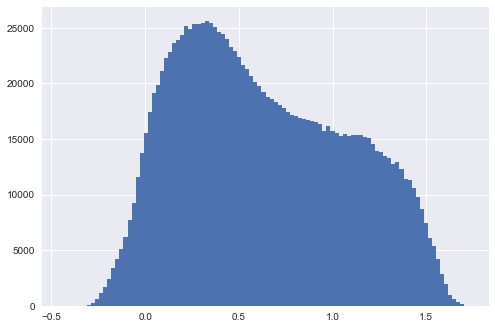

In [27]:
x=plt.hist(quantile_score_frame['desirability_score'],bins=100)

### Top 10 Houses
These are the 10 houses ranked by the desirability score

In [28]:
quantile_score_frame.nlargest(10, 'desirability_score')

,structuretaxvaluedollarcnt_score,bedroomcnt_score,bathroomcnt_score,calculatedfinishedsquarefeet_score,lotsizesquarefeet_score,yearbuilt_score,parcelid,desirability_score
209387,0.002664,0.788953,0.996159,0.996772,0.978609,0.996314,14202712,1.724894
782015,0.007261,0.788953,0.996159,0.997825,0.963362,0.997624,17257315,1.720963
876111,0.001374,0.788953,0.996159,0.994658,0.955507,0.984010,14145142,1.715499
1177315,0.001056,0.788953,0.996159,0.993698,0.993605,0.967803,17300511,1.715250
393266,0.004982,0.788953,0.996159,0.983406,0.963675,0.997004,14201457,1.714075
508981,0.001559,0.788953,0.996159,0.996587,0.986777,0.962090,14232873,1.713104
1027010,0.010693,0.788953,0.996159,0.993676,0.972135,0.984010,17051508,1.712984
1331984,0.008381,0.788953,0.996159,0.998878,0.962523,0.973224,14144920,1.711059
577720,0.003893,0.788953,0.996159,0.995828,0.994223,0.956012,17264250,1.710331
659367,0.003450,0.788953,0.996159,0.998077,0.943581,0.973224,17263523,1.709915


In [29]:
quantile_score_frame.nlargest(10, 'desirability_score')['parcelid']

209387     14202712
782015     17257315
876111     14145142
1177315    17300511
393266     14201457
508981     14232873
1027010    17051508
1331984    14144920
577720     17264250
659367     17263523
Name: parcelid, dtype: int64

### Bottom 10 houses
These are the bottom 10 houses ranked by the desirability score

In [44]:
quantile_score_frame.nsmallest(10, 'desirability_score')

,structuretaxvaluedollarcnt_score,bedroomcnt_score,bathroomcnt_score,calculatedfinishedsquarefeet_score,lotsizesquarefeet_score,yearbuilt_score,parcelid,desirability_score
515493,0.990136,0.288953,0.006787,0.002211,0.015235,0.001365,14132206,-0.440420
1129310,0.961495,0.288953,0.006787,0.004681,0.018869,0.005261,17066219,-0.421968
748124,0.980024,0.288953,0.006787,0.007135,0.025849,0.036680,17097563,-0.416515
461828,0.954598,0.288953,0.006787,0.000223,0.041751,0.062132,14404129,-0.394131
235708,0.986342,0.288953,0.006787,0.067440,0.033187,0.046515,13878336,-0.381646
1079579,0.994777,0.288953,0.006787,0.003160,0.011565,0.171228,13893976,-0.375073
924999,0.933541,0.288953,0.006787,0.000149,0.208086,0.050470,17070566,-0.359110
971268,0.970329,0.288953,0.006787,0.037594,0.350226,0.003637,14118787,-0.351945
235637,0.989538,0.288953,0.006787,0.021173,0.350226,0.054022,13839592,-0.350790
1025246,0.989829,0.288953,0.006787,0.000085,0.486024,0.024701,13951584,-0.350709


In [30]:
quantile_score_frame.nsmallest(10, 'desirability_score')['parcelid']

515493     14132206
1129310    17066219
748124     17097563
461828     14404129
235708     13878336
1079579    13893976
924999     17070566
971268     14118787
235637     13839592
1025246    13951584
Name: parcelid, dtype: int64